<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/01_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install jcopml

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [20]:
df_params = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/parameters.csv')
df_params.head()

,case_num,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,1,train,96.690954,2216.996775,127.801703,0.265198,672.408364,50.103320
2,2,train,45.990485,1494.508214,321.702554,0.109952,532.563399,73.410282
3,3,train,88.322302,2242.513803,427.275505,0.137530,976.777682,37.443929
4,4,train,27.823837,2994.073285,398.741243,0.220836,465.207942,15.788940


In [21]:
df_prods = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/production.csv')
df_prods.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum
0,0,0,0.000000,0.0,0,0.00,0.0
1,0,31,0.084932,26614.0,825035,1740.71,53962.1
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0


In [22]:
# Concatenate df_params and df_prods based on "case_num"
df = pd.merge(df_prods, df_params, on="case_num")

In [24]:
df.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0.000000,0.0,0,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,0.084932,26614.0,825035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [ ]:
# Save df
file_path = '/content/drive/MyDrive/00_History_Matching/Data/df_merged.csv'
df.to_csv(file_path, index=False)

In [30]:

for column in df.columns:
    unique_count = df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")


Number of unique values in column 'case_num': 1000
Number of unique values in column 'days': 121
Number of unique values in column 'years': 121
Number of unique values in column 'oil_prod_rate': 99062
Number of unique values in column 'oil_prod_cum': 105555
Number of unique values in column 'water_inj_rate': 999
Number of unique values in column 'water_inj_cum': 113116
Number of unique values in column 'category': 2
Number of unique values in column 'Kh_Kv': 1000
Number of unique values in column 'inj_rate': 1000
Number of unique values in column 'permeability': 1000
Number of unique values in column 'porosity': 1000
Number of unique values in column 'prod_bhp': 1000
Number of unique values in column 'thickness': 1000


In [34]:
df.columns

Index(['case_num', 'days', 'years', 'oil_prod_rate', 'oil_prod_cum',
       'water_inj_rate', 'water_inj_cum', 'category', 'Kh_Kv', 'inj_rate',
       'permeability', 'porosity', 'prod_bhp', 'thickness'],
      dtype='object')

In [36]:
df.drop(columns=['years', 'oil_prod_rate', 'water_inj_rate', 'water_inj_cum', 'category'], inplace = True)

In [37]:
df.head()

,case_num,days,oil_prod_cum,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,825035,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,1489290,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,2072390,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,2589370,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [39]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named "df"
cases = df['case_num'].unique()

# Initialize empty lists to store the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Iterate over each unique case_num
for case in cases:
    # Filter the data for the current case_num
    df_case = df[df['case_num'] == case]

    # Split the data for the current case_num
    X = df_case.drop(columns='oil_prod_cum')
    y = df_case['oil_prod_cum']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Append the split data to the respective lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Convert the lists to DataFrames
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Print the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (90000, 8)
X_test shape: (31000, 8)
y_train shape: (90000,)
y_test shape: (31000,)


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson'), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 71, 'algo__max_features': 0.6331731119758383, 'algo__min_samples_leaf': 3, 'algo__n_estimators': 200}
0.999900550380952 0.9777230691429848 0.9965596448267091


In [45]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model/model_RF.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF, file_path)

['/content/drive/MyDrive/00_History_Matching/Model/model_RF.pkl']

In [46]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model/model_RF_best_estimator_.pkl'

# Save the trained model to a file
joblib.dump(model_RF.best_estimator_, file_path)

['/content/drive/MyDrive/00_History_Matching/Model/model_RF_best_estimator_.pkl']

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

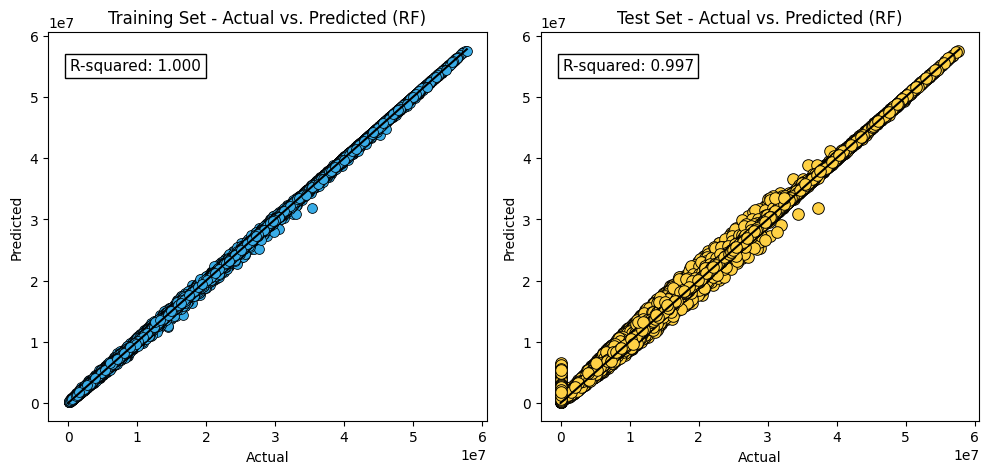

In [60]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [61]:
X.pred

AttributeError: ignored

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
44,0,1364,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
47,0,1457,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
55,0,1705,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
26,0,806,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
...,...,...,...,...,...,...,...,...
120894,999,465,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681
120994,999,3565,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681
120955,999,2356,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681
120977,999,3038,29.653913,1998.328914,160.051346,0.197521,353.949063,62.922681


In [73]:
# Obtain predictions for the test dataset
y_test_pred = model_RF.predict(X_test)

In [76]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
comparison_df.head()

,Actual,Predicted
44,8003440,7.935746e+06
47,8174680,8.243430e+06
4,2589370,3.311536e+06
55,8624850,8.681777e+06
26,6854360,6.954707e+06


In [78]:
# Concatenate comparison_df with X_test
concatenated_df = pd.concat([X_test, comparison_df], axis=1)

concatenated_df.head()

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
44,0,1364,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8003440,7.935746e+06
47,0,1457,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8174680,8.243430e+06
4,0,124,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,2589370,3.311536e+06
55,0,1705,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8624850,8.681777e+06
26,0,806,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,6854360,6.954707e+06


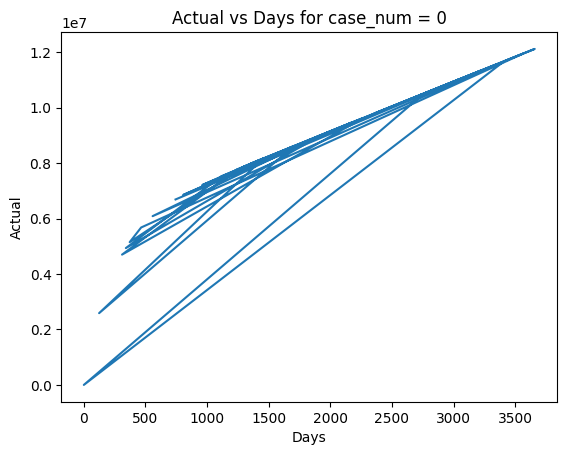

In [79]:
import matplotlib.pyplot as plt

# Filter the data for case_num = 0
filtered_df = concatenated_df[concatenated_df['case_num'] == 0]

# Create the line plot
plt.plot(filtered_df['days'], filtered_df['Actual'])
plt.xlabel('Days')
plt.ylabel('Actual')
plt.title('Actual vs Days for case_num = 0')
plt.show()


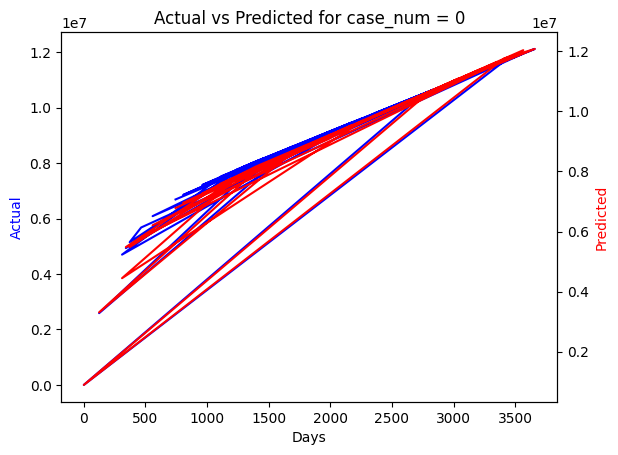

In [80]:
import matplotlib.pyplot as plt

# Filter the data for case_num = 0
filtered_df = concatenated_df[concatenated_df['case_num'] == 0]

# Create the line plot
fig, ax1 = plt.subplots()

# Plot for "Actual" column
ax1.plot(filtered_df['days'], filtered_df['Actual'], color='blue')
ax1.set_xlabel('Days')
ax1.set_ylabel('Actual', color='blue')

# Create a twin Axes for "Predicted" column
ax2 = ax1.twinx()
ax2.plot(filtered_df['days'], filtered_df['Predicted'], color='red')
ax2.set_ylabel('Predicted', color='red')

plt.title('Actual vs Predicted for case_num = 0')
plt.show()
